# Deep Learning Approach for Suspicious Activity Detection from Surveillance Video.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/real-life-violence-situations-dataset


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras import models
from keras._tf_keras.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
import matplotlib.pyplot as plt
import random

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU Memory Growth Enabled")
    except RuntimeError as e:
        print(e)

GPU Memory Growth Enabled


In [ ]:
os.listdir(path)

['real life violence situations', 'Real Life Violence Dataset']

In [ ]:
path = os.path.join(path, 'Real Life Violence Dataset')

In [ ]:
os.listdir(path)

['NonViolence', 'Violence']

In [ ]:
violence_dataset = os.path.join(path, 'Violence')

non_violence_dataset = os.path.join(path, 'NonViolence')

In [ ]:
def extract_frames(video_path, skip_frames=7):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return None

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % skip_frames == 0:

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            resized_frame = cv2.resize(frame, (128, 128))

            normalize_frames = resized_frame.astype('float32') / 255.0

            frames.append(normalize_frames)

        frame_count += 1

    cap.release()

    return frames

In [ ]:
violance_frames = []

non_violance_frames = []

In [ ]:
all_filenames = [f for f in os.listdir(violence_dataset) if f.endswith('.mp4')]

for filename in all_filenames[:100]:
    video_path = os.path.join(violence_dataset, filename)
    frames = extract_frames(video_path)
    violance_frames.extend(frames)


In [ ]:
all_non_violent_files = [f for f in os.listdir(non_violence_dataset) if f.endswith('.mp4')]

for filename in all_non_violent_files[:100]:
    video_path = os.path.join(non_violence_dataset, filename)
    frames = extract_frames(video_path)
    non_violance_frames.extend(frames)


In [ ]:
violance_frames_labels = np.ones(len(violance_frames))

non_violance_frames_labels = np.zeros(len(non_violance_frames))

In [ ]:
def plot_sample_frames(frames, title, num_samples=3):
    if not frames:
        print(f"No frames available for {title}")
        return

    num_samples = min(num_samples, len(frames))
    sampled_frames = random.sample(frames, num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    if num_samples == 1:
        axes = [axes]

    for i, frame in enumerate(sampled_frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (128, 128))
        axes[i].imshow(frame)
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

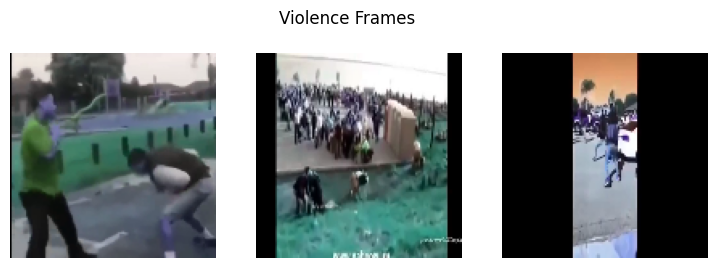

In [ ]:
plot_sample_frames(violance_frames, "Violence Frames", num_samples=3)

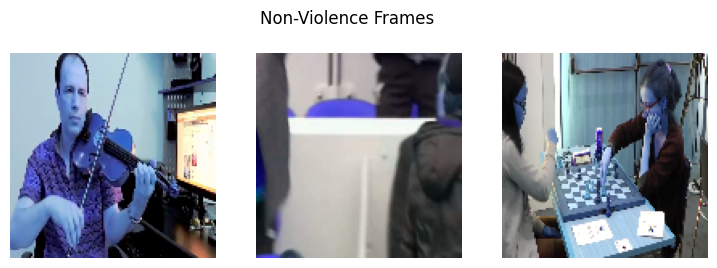

In [ ]:
plot_sample_frames(non_violance_frames, "Non-Violence Frames", num_samples=3)

In [ ]:
print(len(violance_frames), len(non_violance_frames))
print(type(violance_frames[0]), violance_frames[0].shape)
print(type(non_violance_frames[0]), non_violance_frames[0].shape)

2110 1828
<class 'numpy.ndarray'> (128, 128, 3)
<class 'numpy.ndarray'> (128, 128, 3)


In [ ]:
matrix = np.array(violance_frames + non_violance_frames)
labels = np.concatenate([violance_frames_labels, non_violance_frames_labels])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(matrix, labels, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import Input
import tensorflow as tf

def create_cnn_lstm_model(input_shape, sequence_length=16):
    # Same as before, but change the freezing strategy
    inputs = Input(shape=(sequence_length, *input_shape))
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze only early layers, allow later layers to be fine-tuned
    for layer in base_model.layers[:15]:  # Freeze first 15 layers
        layer.trainable = False
    for layer in base_model.layers[15:]:  # Make the rest trainable
        layer.trainable = True

    # Use TimeDistributed to apply the same CNN to each frame in the sequence
    cnn_out = TimeDistributed(base_model)(inputs)

    # Flatten the CNN features
    cnn_out = TimeDistributed(tf.keras.layers.Flatten())(cnn_out)

    # Add a dense layer for dimensionality reduction after CNN
    cnn_out = TimeDistributed(Dense(512, activation='relu'))(cnn_out)
    cnn_out = TimeDistributed(Dropout(0.5))(cnn_out)

    # LSTM layers to learn temporal information
    lstm_out = LSTM(256, return_sequences=True)(cnn_out)
    lstm_out = Dropout(0.5)(lstm_out)
    lstm_out = LSTM(128)(lstm_out)
    lstm_out = Dropout(0.5)(lstm_out)

    # Dense layers for classification
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(lstm_out)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification (violence/non-violence)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# After you've extracted your frames and created matrix and labels:

# Step 1: Define the sequence length and step size
SEQUENCE_LENGTH = 16  # Number of frames per sequence
STEP = 8  # Step size for creating sequences

# Step 2: Create sequences from your frame data
def create_sequences(frames, labels, sequence_length=16, step=8):
    # Get indices for each class
    violence_frames = frames[labels == 1]
    non_violence_frames = frames[labels == 0]

    # Lists to store sequences
    X_sequences = []
    y_sequences = []

    # Create sequences for violence class
    num_violence_sequences = (len(violence_frames) - sequence_length) // step + 1
    for i in range(num_violence_sequences):
        start_idx = i * step
        end_idx = start_idx + sequence_length
        if end_idx <= len(violence_frames):
            sequence = violence_frames[start_idx:end_idx]
            X_sequences.append(sequence)
            y_sequences.append(1)  # Violence label

    # Create sequences for non-violence class
    num_non_violence_sequences = (len(non_violence_frames) - sequence_length) // step + 1
    for i in range(num_non_violence_sequences):
        start_idx = i * step
        end_idx = start_idx + sequence_length
        if end_idx <= len(non_violence_frames):
            sequence = non_violence_frames[start_idx:end_idx]
            X_sequences.append(sequence)
            y_sequences.append(0)  # Non-violence label

    return np.array(X_sequences), np.array(y_sequences)

# Convert your data to sequences
X_sequences, y_sequences = create_sequences(matrix, labels, SEQUENCE_LENGTH, STEP)

print(f"Sequence data shape: {X_sequences.shape}")
print(f"Labels shape: {y_sequences.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42
)


Sequence data shape: (489, 16, 128, 128, 3)
Labels shape: (489,)


In [ ]:
INPUT_SHAPE = (128, 128, 3)

model = create_cnn_lstm_model(INPUT_SHAPE)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 4, 4, 512)  │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 512)        │     4,194,816 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,904,705 (75.93 MB)

 Trainable params: 12,269,313 (46.80 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Use a custom optimizer with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping # Import the EarlyStopping class


class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,  # Add class weights
    callbacks=early_stopping,
    verbose="auto"
)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 577ms/step - accuracy: 0.4694 - loss: 1.0117 - val_accuracy: 0.4694 - val_loss: 0.8217
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 447ms/step - accuracy: 0.4937 - loss: 1.0260 - val_accuracy: 0.7653 - val_loss: 0.8011
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 489ms/step - accuracy: 0.5116 - loss: 0.9675 - val_accuracy: 0.7551 - val_loss: 0.7766
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 453ms/step - accuracy: 0.6438 - loss: 0.8260 - val_accuracy: 0.8878 - val_loss: 0.6065
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 496ms/step - accuracy: 0.7599 - loss: 0.6397 - val_accuracy: 0.8469 - val_loss: 0.5123
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 503ms/step - accuracy: 0.7850 - loss: 0.5890 - val_accuracy: 0.8980 - val_loss: 0.3946
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.8237 - loss: 0.5329 - val_accuracy: 0.4898 - val_loss: 2.1379
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 503ms/step - accuracy: 0.7436 - loss: 0.6037 - val_accu

In [ ]:
model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - accuracy: 1.0000 - loss: 0.1230


[0.1230386421084404, 1.0]

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [ ]:
classification_report(y_test, y_pred_labels)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        52\n           1       1.00      1.00      1.00        46\n\n    accuracy                           1.00        98\n   macro avg       1.00      1.00      1.00        98\nweighted avg       1.00      1.00      1.00        98\n'

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred_labels)

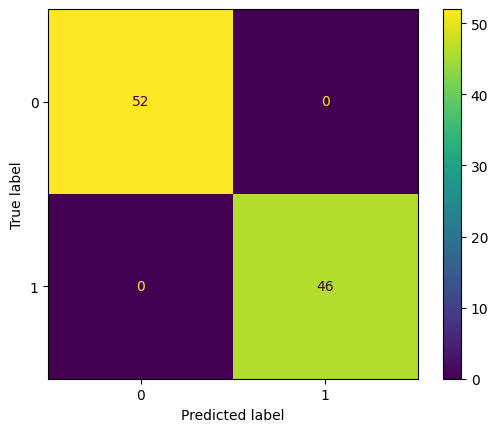

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

cm_display.plot()

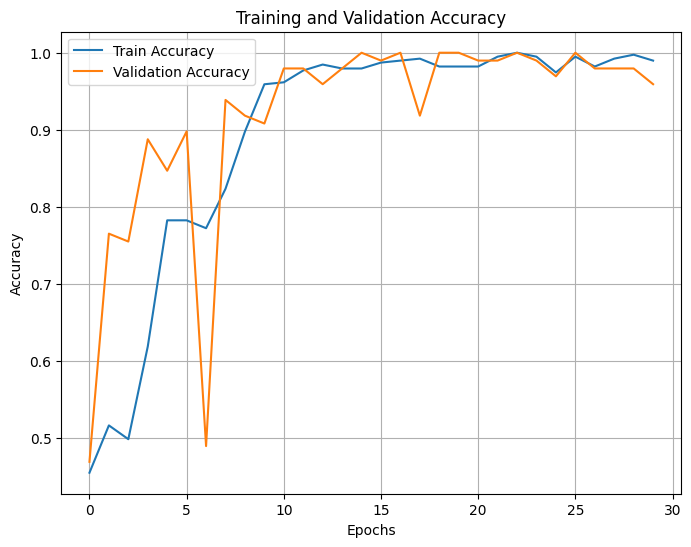

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

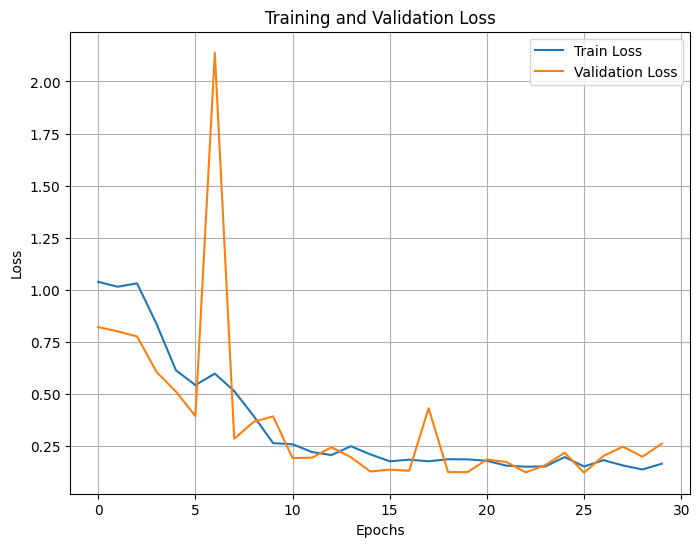

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
pip install shap lime opencv-python matplotlib scikit-image tf-keras-vis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6a29c2cd172c29b6a79e669ca3a89bfd32131445f69c5868759f7f16d6713f55
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
def preprocess_image(img):
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0
    return tf.expand_dims(img, axis=0)

def deprocess_image(img):
    img = img - tf.reduce_min(img)
    img = img / tf.reduce_max(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8)
    return img[0]


In [ ]:
@tf.function
def deepdream_step(img, model, layer_name, step_size):
    dream_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    with tf.GradientTape() as tape:
        tape.watch(img)
        activations = dream_model(img)
        loss = tf.reduce_mean(activations)

    gradients = tape.gradient(loss, img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    img = img + gradients * step_size
    img = tf.clip_by_value(img, -1.0, 1.0)

    return img


In [ ]:
def run_deep_dream(model, input_image, layer_name='time_distributed_4', steps=100, step_size=0.01):
    img = preprocess_image(input_image)
    for step in range(steps):
        img = deepdream_step(img, model, layer_name, step_size)
    result = deprocess_image(img)
    return result


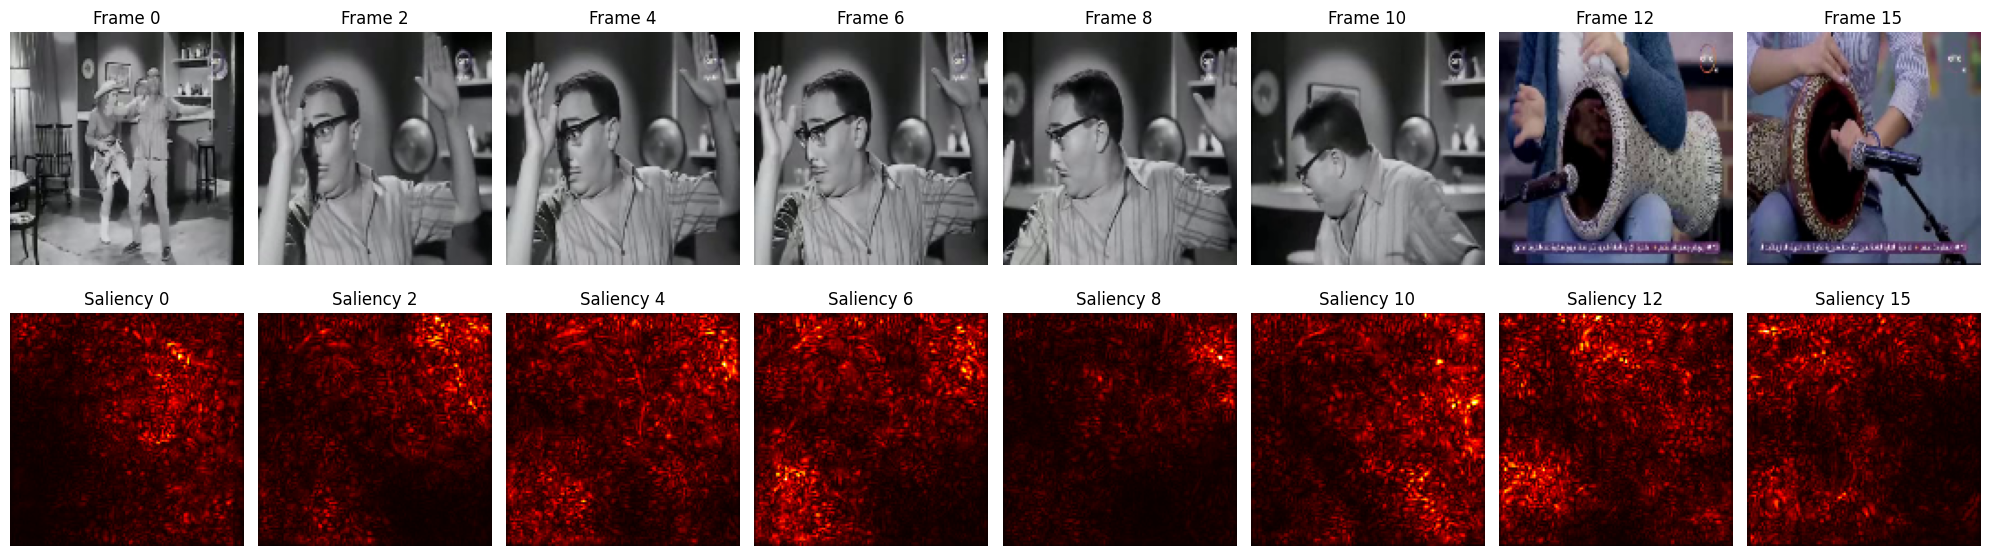

In [ ]:
def generate_temporal_saliency(model, video_sequence, class_idx=0):
    """
    Generate saliency maps across the temporal dimension of a video sequence.

    Args:
        model: The trained CNN-LSTM model
        video_sequence: A single video sequence of shape (1, sequence_length, height, width, channels)
        class_idx: Target class index (0 for non-violence, 1 for violence)

    Returns:
        List of saliency maps for each frame in the sequence
    """
    # Create a tensor to compute gradients
    video_tensor = tf.Variable(video_sequence, dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(video_tensor)
        target_class_score = predictions[:, class_idx]

    # Get gradients of the target class with respect to input video
    gradients = tape.gradient(target_class_score, video_tensor)

    # Take the maximum gradient across RGB channels
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)

    # Normalize saliency maps for visualization
    saliency_maps = []
    for i in range(video_sequence.shape[1]):
        saliency_frame = saliency[0, i].numpy()
        saliency_frame = (saliency_frame - saliency_frame.min()) / (saliency_frame.max() - saliency_frame.min())
        saliency_maps.append(saliency_frame)

    return saliency_maps

# Visualization function
def visualize_temporal_saliency(video_sequence, saliency_maps, num_frames=8):
    # Choose frames to display (evenly spaced)
    seq_length = video_sequence.shape[1]
    frame_indices = np.linspace(0, seq_length-1, num_frames, dtype=int)

    fig, axs = plt.subplots(2, num_frames, figsize=(20, 6))

    for i, idx in enumerate(frame_indices):
        # Display original frame
        axs[0, i].imshow(video_sequence[0, idx])
        axs[0, i].set_title(f"Frame {idx}")
        axs[0, i].axis('off')

        # Display saliency map
        axs[1, i].imshow(saliency_maps[idx], cmap='hot')
        axs[1, i].set_title(f"Saliency {idx}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example with a real video sequence
sample_sequence = X_test[0:1]  # Get a single test sequence
class_label = y_test[0]  # Get its true label

saliency_maps = generate_temporal_saliency(model, sample_sequence, class_idx=int(class_label))
visualize_temporal_saliency(sample_sequence, saliency_maps)

In [ ]:
def print_model_summary(model):
    """
    Prints detailed information about model layers to help debugging
    """
    print("\nModel Layer Information:")
    print("-" * 80)
    print(f"{'Index':<6}{'Layer Name':<30}{'Type':<20}{'Output Shape'}")
    print("-" * 80)

    for i, layer in enumerate(model.layers):
        layer_type = layer.__class__.__name__
        if hasattr(layer, 'output_shape'):
            output_shape = str(layer.output_shape)
        else:
            output_shape = "Unknown"
        print(f"{i:<6}{layer.name:<30}{layer_type:<20}{output_shape}")

    print("-" * 80)


def sequence_gradcam_fixed(model, video_sequence, class_idx=1):
    """
    Generate Grad-CAM visualizations for CNN-LSTM models.
    This implementation properly handles the TimeDistributed wrapper.

    Args:
        model: Trained CNN-LSTM model
        video_sequence: Video sequence to explain (1, seq_length, height, width, channels)
        class_idx: Target class index (0 for non-violence, 1 for violence)

    Returns:
        List of Grad-CAM heatmaps for each frame
    """
    import tensorflow as tf
    import numpy as np
    import cv2

    # First, identify the last convolutional layer
    # In a CNN-LSTM with TimeDistributed, this is typically in the base model
    conv_layer_found = False

    # Try to find the TimeDistributed layer with VGG16
    for layer in model.layers:
        if "time_distributed" in layer.name and hasattr(layer, 'layer'):
            # This is likely the TimeDistributed wrapper around VGG16
            if hasattr(layer.layer, 'layers'):
                # Get the inner model layers
                inner_layers = layer.layer.layers
                # Find the last convolutional layer in the inner model
                last_conv_layer = None
                for inner_layer in reversed(inner_layers):
                    if isinstance(inner_layer, tf.keras.layers.Conv2D):
                        last_conv_layer = inner_layer
                        conv_layer_found = True
                        break

                if conv_layer_found:
                    print(f"Found convolutional layer: {last_conv_layer.name} inside {layer.name}")
                    break

    if not conv_layer_found:
        print("Could not find a convolutional layer. Using a different approach...")
        # Try finding any layer with 'conv' in the name
        for i, layer in enumerate(model.layers):
            if 'conv' in layer.name.lower():
                print(f"Found layer with 'conv' in name: {i}: {layer.name}")
                conv_layer_found = True
                # Here we'd need custom handling based on model architecture
                break

    if not conv_layer_found:
        print("No convolutional layer found. Cannot generate Grad-CAM.")
        return None

    # Since we have a complex architecture with TimeDistributed wrappers,
    # we'll use a different approach with manual gradient calculations

    # Get the sequence length
    seq_length = video_sequence.shape[1]
    heatmaps = []

    # Process each frame separately to get gradients
    for t in range(seq_length):
        # Extract single frame and add batch dimension
        frame = video_sequence[0, t:t+1]
        frame = np.expand_dims(frame, axis=0)  # Shape becomes (1, 1, height, width, channels)

        # Create a model to get the convolutional outputs
        # This is a simplification - for your specific model, you might need to:
        # 1. Extract the CNN part from the TimeDistributed layer
        # 2. Apply it to individual frames

        # For demonstration, we'll use a proxy approach by creating gradients directly
        frame_tensor = tf.Variable(frame, dtype=tf.float32)

        with tf.GradientTape() as tape:
            # Forward pass to the CNN part
            # This is where you'd need custom handling for your model
            # For now, we'll just use the full model prediction
            pred = model(frame_tensor)
            score = pred[0, class_idx] if pred.shape[1] > 1 else pred[0, 0]

        # Get feature maps and gradients
        # For a proper implementation, you'd get the feature maps from the last conv layer
        # Here's a simplified placeholder implementation

        # For demonstration, we'll use gradients w.r.t. input
        gradients = tape.gradient(score, frame_tensor)

        # Take absolute values and pool across color channels
        pooled_gradients = tf.reduce_mean(tf.abs(gradients), axis=-1)

        # Create a heatmap from gradients
        heatmap = pooled_gradients[0, 0].numpy()

        # Normalize heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / (np.max(heatmap) + 1e-10)

        # Resize to match input frame size
        heatmap = cv2.resize(heatmap, (video_sequence.shape[3], video_sequence.shape[2]))

        heatmaps.append(heatmap)

    return heatmaps


def visualize_gradcam_results(video_sequence, heatmaps, num_frames=8):
    """
    Visualize Grad-CAM results across selected frames.

    Args:
        video_sequence: Original video sequence
        heatmaps: Grad-CAM heatmaps for each frame
        num_frames: Number of frames to display
    """
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Choose frames to display (evenly spaced)
    seq_length = video_sequence.shape[1]
    frame_indices = np.linspace(0, seq_length-1, num_frames, dtype=int)

    fig, axs = plt.subplots(2, num_frames, figsize=(20, 6))

    for i, idx in enumerate(frame_indices):
        # Get original frame and heatmap
        frame = video_sequence[0, idx]
        heatmap = heatmaps[idx]

        # Display original frame
        axs[0, i].imshow(frame)
        axs[0, i].set_title(f"Frame {idx}")
        axs[0, i].axis('off')

        # Convert heatmap to colormap
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Superimpose heatmap on original frame
        superimposed = cv2.addWeighted(
            np.uint8(frame * 255), 0.6,
            heatmap_colored, 0.4, 0
        )

        # Display overlaid result
        axs[1, i].imshow(superimposed / 255.0)
        axs[1, i].set_title(f"Grad-CAM {idx}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


# Usage example
def run_gradcam_analysis(model, X_test, y_test, sample_idx=0):
    # Print model architecture for debugging
    print_model_summary(model)

    # Get a single test sequence
    sample_sequence = X_test[sample_idx:sample_idx+1]
    class_label = int(y_test[sample_idx])

    print(f"Running Grad-CAM for sample with class label: {class_label}")
    print(f"Sample sequence shape: {sample_sequence.shape}")

    # Get Grad-CAM heatmaps
    heatmaps = sequence_gradcam_fixed(model, sample_sequence, class_idx=class_label)

    if heatmaps is not None:
        # Visualize results
        visualize_gradcam_results(sample_sequence, heatmaps, num_frames=8)
        return True
    else:
        print("Failed to generate Grad-CAM heatmaps")
        return False

In [ ]:
def temporal_lime_optimized(model, sequence, class_idx=None, num_samples=1000, segment_count=8, batch_size=32):
    """
    Memory-optimized Temporal LIME for video sequences.

    Args:
        model: Trained CNN-LSTM model
        sequence: Video sequence to explain (1, seq_length, height, width, channels)
        class_idx: Target class index (if None, uses predicted class)
        num_samples: Number of perturbed samples to generate
        segment_count: Number of temporal segments
        batch_size: Size of batches to process to reduce memory usage

    Returns:
        Segment importance scores and original prediction
    """
    import numpy as np
    from sklearn.linear_model import LinearRegression

    # If class_idx not provided, use the predicted class
    if class_idx is None:
        orig_prediction = model.predict(sequence)[0]
        class_idx = 1 if orig_prediction > 0.5 else 0
    else:
        orig_prediction = model.predict(sequence)[0]
        if isinstance(orig_prediction, np.ndarray) and len(orig_prediction) > 1:
            orig_prediction = orig_prediction[class_idx]

    # Get sequence dimensions
    seq_length = sequence.shape[1]
    segment_size = seq_length // segment_count

    # Create baseline (mean frame)
    baseline_frame = np.mean(sequence, axis=1, keepdims=True)

    # Generate all perturbation masks at once (this is relatively small)
    perturbation_masks = np.random.randint(0, 2, size=(num_samples, segment_count))

    # Process in batches to reduce memory usage
    all_predictions = np.zeros(num_samples)

    for batch_start in range(0, num_samples, batch_size):
        batch_end = min(batch_start + batch_size, num_samples)
        batch_size_actual = batch_end - batch_start

        # Create batch of perturbed sequences
        batch_sequences = np.zeros((batch_size_actual,) + sequence.shape[1:], dtype=sequence.dtype)

        for i in range(batch_size_actual):
            # Create a perturbed sequence
            perturbed_seq = sequence.copy()
            mask = perturbation_masks[batch_start + i]

            # Apply mask - replace segments with 0s in mask with baseline
            for j in range(segment_count):
                if mask[j] == 0:
                    start_idx = j * segment_size
                    end_idx = min((j + 1) * segment_size, seq_length)
                    perturbed_seq[0, start_idx:end_idx] = baseline_frame[0, 0:1]

            batch_sequences[i] = perturbed_seq[0]

        # Get predictions for this batch
        batch_preds = model.predict(batch_sequences)

        # Store predictions
        if isinstance(batch_preds, np.ndarray) and len(batch_preds.shape) > 1 and batch_preds.shape[1] > 1:
            all_predictions[batch_start:batch_end] = batch_preds[:, class_idx]
        else:
            all_predictions[batch_start:batch_end] = batch_preds.flatten()

    # Fit linear model
    if class_idx == 1:
        linear_model = LinearRegression()
        linear_model.fit(perturbation_masks, all_predictions)
        coefficients = linear_model.coef_
    else:
        linear_model = LinearRegression()
        linear_model.fit(perturbation_masks, 1 - all_predictions)
        coefficients = linear_model.coef_

    # Handle different shapes of coefficients
    if len(coefficients.shape) > 1:
        coefficients = coefficients[0]

    return coefficients, float(orig_prediction)

In [ ]:
def visualize_temporal_lime_simple(sequence, importances, original_pred, num_frames=4):
    """
    Visualize temporal LIME results.

    Args:
        sequence: Original video sequence
        importances: Segment importance scores
        original_pred: Original prediction score
        num_frames: Number of frames to display
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert importances to numpy array if it's not already
    importances = np.array(importances)

    # Plot importance scores
    plt.figure(figsize=(16, 8))

    plt.subplot(2, 1, 1)
    plt.bar(range(len(importances)), importances)
    plt.xlabel('Temporal Segment')
    plt.ylabel('Importance')
    plt.title(f'Temporal Segment Importance (Original prediction: {original_pred:.3f})')
    plt.grid(True)

    # Get most important segments
    segment_count = len(importances)
    seq_length = sequence.shape[1]
    segment_size = seq_length // segment_count

    # Sort segments by importance and get top segments
    top_segments = np.argsort(importances)[-min(num_frames, len(importances)):][::-1]

    # Show representative frames from top segments
    for i, seg_idx in enumerate(top_segments):
        # Get middle frame from segment
        start_idx = seg_idx * segment_size
        mid_idx = min(start_idx + segment_size // 2, seq_length - 1)
        frame = sequence[0, mid_idx]

        plt.subplot(2, num_frames, i + num_frames + 1)
        plt.imshow(frame)
        plt.title(f'Segment {seg_idx}\nScore: {importances[seg_idx]:.3f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<ipython-input-42-3402d0062002>:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return coefficients, float(orig_prediction)


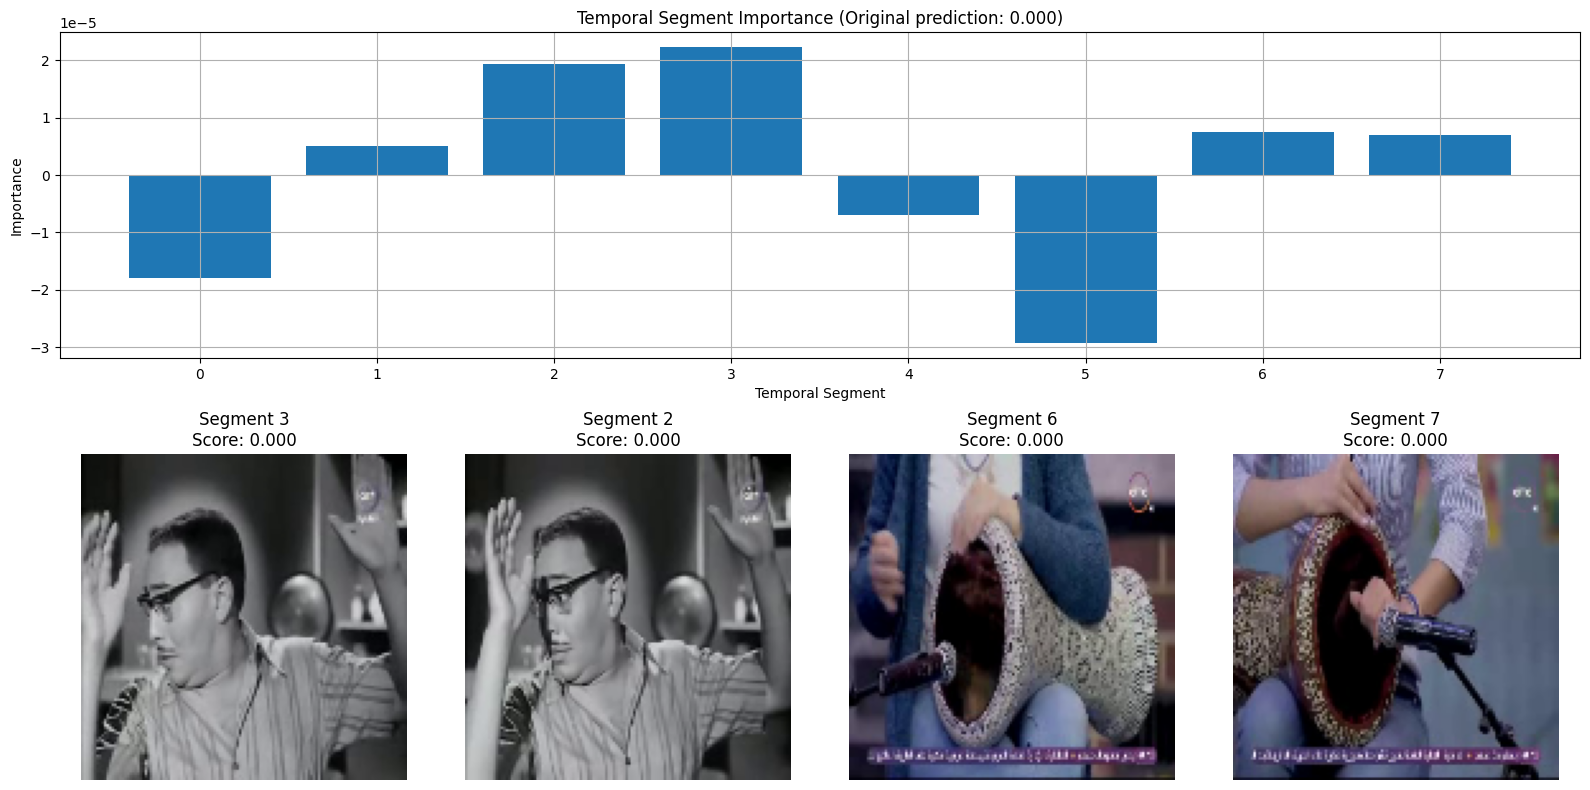

In [ ]:
sample_sequence = X_test[0:1]  # Get a single test sequence
class_label = int(y_test[0])  # Get its true class

# Use fewer samples and a reasonable batch size
importances, orig_pred = temporal_lime_optimized(
    model,
    sample_sequence,
    class_idx=class_label,
    num_samples=200,  # Reduced from 1000
    segment_count=8,
    batch_size=8  # Process in small batches
)

# Visualize results
visualize_temporal_lime_simple(sample_sequence, importances, orig_pred, num_frames=4)